In [1]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt
# %matplotlib qt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os
%load_ext memory_profiler

In [2]:
def cross_dot(n1,n2,maxlag,step,binSize):
    t = np.arange(-maxlag,maxlag+1,step)
    Pij = np.zeros_like(t,dtype = np.float)
    for i,u in enumerate(t): 
        Pij[i] = np.dot(np.roll(n1.astype(np.uint16),u),n2)/len(n1)
    return t*binSize,Pij

def cross_corr(n1,n2,maxlag,step,binSize):
    t = np.arange(-maxlag,maxlag+1,step)
    Cij = np.zeros_like(t,dtype = np.float)
    for i,u in enumerate(t):
        Cij[i] = np.corrcoef(np.roll(n1,u),n2)[0,1]
    return t*binSize,Cij

def crosscorrelogram(neurons,binSize,win,fast = False):
    if isinstance(neurons,nts.time_series.Tsd): 
        neurons = np.array(neurons,'object')
    winLen = int((win[1] - win[0])/binSize)
    window = np.arange(winLen,dtype = int)-int(winLen/2)
    crosscorr = np.empty((winLen,len(neurons),len(neurons)),dtype = np.float16)
    last_spike = np.max([n.as_units('s').index[-1] for n in neurons])
    t,binned = bk.compute.binSpikes(neurons,binSize,start = 0, stop = last_spike+win[-1],fast = fast)

    for i,n in tqdm(enumerate(neurons),total = len(neurons)):
        stimulus = n.as_units('s').index
        stim_bin = (stimulus/binSize).astype('int')
        psth = np.empty((stimulus.size,len(neurons),winLen),dtype = 'float16')

        for j,t in enumerate(stim_bin):
            psth[j] = binned[:,t+window]
#             psth[j][:,window == 0] -= 1

        psth = np.sum(psth,0).T
        crosscorr[:,i] = psth
        t = window*binSize
        
    return t,crosscorr

In [3]:
bk.load.current_session_linux()
neurons,metadata = bk.load.loadSpikeData(bk.load.path)

state = bk.load.states()
neurons,metadata = bk.load.loadSpikeData(bk.load.path)
# t,binned = bk.compute.binSpikes(neurons,0.001,fast = True,centered=False)
# binned[binned > 0] = 1
# binned = binned.T

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


In [9]:
t,c = crosscorrelogram(neurons,0.05,[-.5,.5],fast = True)

100%|██████████| 252/252 [02:37<00:00,  1.60it/s]


In [ ]:
%time t,p = cross_dot(binned[:,0],binned[:,0],50,1,0.01)

In [11]:
%matplotlib qt
t,c = crosscorrelogram(neurons,0.05,[-.5,.5],fast = True)


In [14]:
a = np.arange(0,10**2)
a = a.reshape((10,10))
fig,ax = plt.subplot_mosaic(a)
for i in range(10):
    for j in range(10):
        if i == j: c[t==0,i,j] = 0
        ax[a[i,j]].bar(t,c[:,i,j],0.05)

In [240]:
t,c = crosscorrelogram(neurons,0.01,[-0.5,0.5])

100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [22:10<00:00,  5.28s/it]


In [358]:
metadata.index

RangeIndex(start=0, stop=252, step=1)

IndexError: boolean index did not match indexed array along dimension 2; dimension is 1 but corresponding boolean dimension is 252

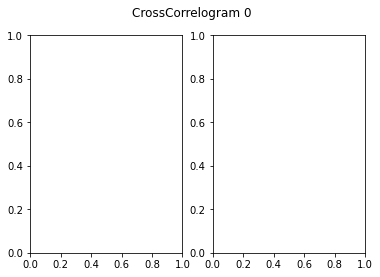

In [7]:
f = metadata[metadata.Region=='BLA'].index
for i in range(252):
    fig,ax = plt.subplot_mosaic(['AB'])
    plt.suptitle(f'CrossCorrelogram {i}')
    ax['A'].imshow(scipy.stats.zscore(c[:,i,metadata.Region == 'Hpc'].astype(np.int64)).T,aspect = 'auto')
    ax['A'].set_title('With Hpc')
    ax['A'].set_xlabel('Time(s)')

    ax['B'].imshow(scipy.stats.zscore(c[:,i,metadata.Region == 'BLA'].astype(np.int64)).T,aspect = 'auto')
    ax['B'].set_title('With BLA')
    ax['B'].set_xlabel('Time(s)')


In [349]:
np.sum(metadata.Region == 'Hpc')

60

In [354]:
plt.figure()
plt.bar(t,scipy.stats.zscore(c[:,33,19].astype(np.int16)),0.01)

<BarContainer object of 100 artists>

In [355]:
scipy.stats.zscore(c[:,0,0].astype(np.int64))

array([-0.4208931 , -0.25509774, -0.32777516, -0.28689411, -0.49584169,
       -0.42543544, -0.49584169, -0.44587596, -0.44587596, -0.47540116,
       -0.44587596, -0.45950298, -0.35048685, -0.40499491, -0.36638504,
       -0.3686562 , -0.30506346, -0.20740318, -0.23238605, -0.33685983,
       -0.29824996, -0.22330137, -0.23919955, -0.22557254, -0.22557254,
       -0.14153927, -0.27553826, -0.21421669, -0.24828423, -0.31641931,
       -0.18242032, -0.11882758, -0.18242032, -0.04387899,  0.13554339,
        0.11510286,  0.22411899,  0.1196452 ,  0.10374701, -0.0211673 ,
       -0.1324546 , -0.30279229, -0.24374189, -0.191505  , -0.08703121,
        0.16506859,  0.36947383,  0.80780951,  2.01607159,  3.29019758,
        7.77802816,  3.32653629,  2.02061393,  0.81008067,  0.36720266,
        0.16279742, -0.0802177 , -0.19604734, -0.24147072, -0.30279229,
       -0.1324546 , -0.02343847,  0.10601818,  0.1196452 ,  0.22411899,
        0.11510286,  0.13100105, -0.04160782, -0.18242032, -0.11

In [109]:
binSize = 0.01

In [101]:
binned = binned[:,0:10]

In [193]:
a = np.corrcoef(np.roll(binned[:,0],0),binned.T)

In [194]:
plt.imshow(a)

In [226]:
r = np.cov(binned[:,0],binned[:,5])/np.sqrt(np.cov(binned[:,0],binned[:,5])**2)

In [231]:
b = np.cov(binned[:,0],binned[:,5])

In [229]:
a = np.sqrt(np.cov(binned[:,0],binned[:,5])**2)

array([[1., 1.],
       [1., 1.]])

In [201]:
t = np.arange(-20,20,1)
P = np.empty(shape = (len(t),binned.shape[1],binned.shape[1]),dtype = np.int32)
binned = binned.astype(np.int32)
for i in tqdm(range(binned.shape[1])):
    for j,u in enumerate(t):
        P[j,i] = np.dot(np.roll(binned[:,i],u),binned)
t = t*binSize

 15%|███████████▌                                                                   | 37/252 [10:49<1:02:53, 17.55s/it]


KeyboardInterrupt: 

In [176]:
plt.imshow(z[i],aspect = 'auto')

In [170]:
z = P[:,metadata.Region == 'Hpc'][:,:,metadata.Region == 'BLA'].reshape(40,-1).T

In [175]:
i = np.argsort(np.argmax(z,1))

In [159]:
plt.bar(t,P[:,0,80],0.010)

<BarContainer object of 40 artists>

In [157]:
plt.bar(t,P[:,0,0],0.025)

<BarContainer object of 40 artists>

In [63]:

P = np.empty(shape = (len(t),binned.shape[1],binned.shape[1]))
for i in tqdm(range(binned.shape[1])):
        t,Pij = cross_dot(binned[:,i],binned,20,1,0.025)


  0%|                                                                                          | 0/252 [00:00<?, ?it/s]


ValueError: setting an array element with a sequence.

In [59]:
%timeit P = np.dot(binned.astype(np.int16).T,binned)

31.4 s ± 36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
%time crosscorrelogram(neurons,0.025,[-0.5, 0.5])

100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [09:28<00:00,  2.25s/it]

Wall time: 9min 38s


(array([-0.5  , -0.475, -0.45 , -0.425, -0.4  , -0.375, -0.35 , -0.325,
        -0.3  , -0.275, -0.25 , -0.225, -0.2  , -0.175, -0.15 , -0.125,
        -0.1  , -0.075, -0.05 , -0.025,  0.   ,  0.025,  0.05 ,  0.075,
         0.1  ,  0.125,  0.15 ,  0.175,  0.2  ,  0.225,  0.25 ,  0.275,
         0.3  ,  0.325,  0.35 ,  0.375,  0.4  ,  0.425,  0.45 ,  0.475]),
 array([[[1632.,  731.,  289., ...,   21.,   19.,  128.],
         [ 673., 2200.,  493., ...,   74.,   47.,  199.],
         [ 271.,  518.,  667., ...,   40.,   46.,  125.],
         ...,
         [  33.,   73.,   40., ...,   56.,   11.,   22.],
         [  26.,   50.,   35., ...,    5.,   28.,   15.],
         [ 122.,  208.,  121., ...,   13.,   21.,  168.]],
 
        [[1717.,  709.,  257., ...,   24.,   18.,  106.],
         [ 713., 2200.,  508., ...,   56.,   50.,  207.],
         [ 275.,  475.,  632., ...,   40.,   28.,  111.],
         ...,
         [  53.,   84.,   47., ...,   59.,    6.,   20.],
         [  19.,   45.,   3

In [47]:
P[0,0]

13108

In [57]:
%timeit Pij = np.dot(binned[:,0].astype(np.int16),binned[:,0])

2.81 ms ± 5.23 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
Pij

13108

In [34]:
%time t,Pij = cross_dot(binned[:,0],binned[:,i],100,1,0.025)
%time t,Cij = cross_corr(binned[:,0],binned[:,i],100,1,0.025)
%time tc,psth = crosscorrelogram([neurons[0],neurons[i]],0.025,[-2, 2])

Wall time: 1.25 s


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Wall time: 5.31 s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]

Wall time: 396 ms


NameError: name 'binned' is not defined

NameError: name 'binned' is not defined

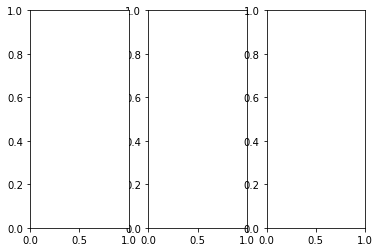

In [6]:
for i in range(70,90):
    figs,ax = plt.subplot_mosaic('ABC')
    %time t,Pij = cross_dot(binned[:,0],binned[:,i],100,1,0.025)
    t,Cij = cross_corr(binned[:,0],binned[:,i],100,1,0.025)
    tc,psth = crosscorrelogram([neurons[0],neurons[i]],0.025,[-2, 2])
    
    ax['A'].bar(t,Pij,0.025)
    ax['B'].bar(t,Cij,0.025)
    ax['C'].bar(tc,psth[:,0,1],0.025)

In [154]:
print(np.dot(binned[:,2],binned[:,2]))
binned = binned.astype(np.int32)
print(np.dot(binned[:,2],binned[:,2]))

-63
14273


In [139]:
binned[:, 2].shape

(907199,)

In [140]:
binned[:,2][0:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int8)

In [79]:
a = [0, 0, 0, 1, 0, 0, 0]
b = [0, 0, 1, 0, 0, 0, 0]

In [81]:
np.dot(binned[:,0],binned[:,0])

52

In [147]:
binned.dtype

dtype('int8')

In [149]:
np.unique(binned[:,2])

array([0, 1], dtype=int8)

In [153]:
np.dot(binned[:, 2][500:5000],binned[:, 2][500:5000])

127

In [145]:
np.dot(binned[:, 2][:], binned[:, 2][:])

-63

Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy
You are using 0.001 ms bins with the function fast off. Consider using "Fast = True" in order to speed up the computations


100%|██████████| 1/1 [00:00<00:00, 95.02it/s]


Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy
You are using 0.001 ms bins with the function fast off. Consider using "Fast = True" in order to speed up the computations


100%|██████████| 1/1 [00:00<00:00, 44.97it/s]


<BarContainer object of 400 artists>

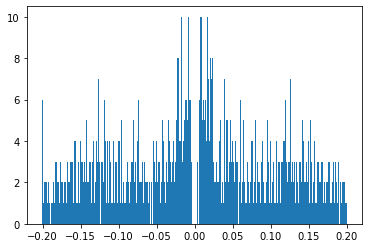

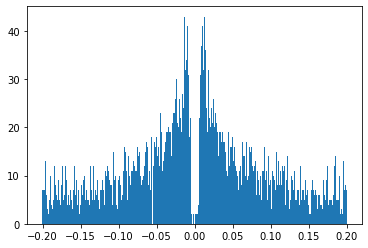

In [5]:
neurons,metadata = bk.load.loadSpikeData(bk.load.path)
i = 10

plt.figure()
for i,n in enumerate(neurons):
    neurons[i] = n.restrict(state['Rem'])
t,c = bk.compute.crosscorrelogram(neurons[[i]],0.001,[-0.2,0.2])
c[t==0,0,0] = 0
plt.bar(t,c[:,0,0],t[1]-t[0])
neurons,metadata = bk.load.loadSpikeData(bk.load.path)
plt.figure()  
for i,n in enumerate(neurons):
    neurons[i] = n.restrict(state['sws'])
t,c = bk.compute.crosscorrelogram(neurons[[i]],0.001,[-0.2,0.2])
c[t==0,0,0] = 0
plt.bar(t,c[:,0,0],t[1]-t[0])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.09it/s]


<BarContainer object of 400 artists>

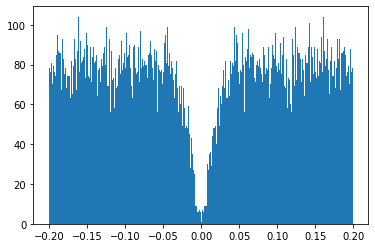

In [95]:
metadata.iloc[90]

Rat         8
Day         6
Shank       8
Id          6
Region    BLA
Type      Pyr
Name: 90, dtype: object

In [36]:
t,b = bk.compute.binSpikes(neurons[244:245],binSize= 1 )

In [15]:
t,b = bk.compute.binSpikes(neurons,0.025)

In [21]:
c = np.corrcoef(b)

In [22]:
np.fill_diagonal(c,0)

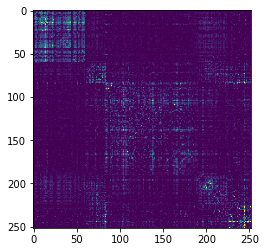

In [26]:
plt.imshow(c)
plt.clim(0,0.05)

In [ ]:
X  = b.T

In [37]:
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(X, 'single')

labelList = range(0, 255)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

KeyboardInterrupt: 